In [2]:
from astropy.io import fits
hdulist = fits.open('TIC_206544316_lc.fits')
hdulist.info()

Filename: TIC_206544316_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   326249R x 3C   [D, E, E]   


In [3]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =               326249 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TIME    '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'FLUX    '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'FLUX_ERR'        

In [4]:
from astropy.table import Table
data = Table(hdulist[1].data)
data

TIME,FLUX,FLUX_ERR
float64,float32,float32
1325.2982014270149,0.95437646,0.0027395028
1325.2995903551605,0.9531791,0.0027382306
1325.3009792830733,0.95127153,0.0027390444
1325.3023682112187,0.95149374,0.0027445504
1325.3037571393643,0.95668817,0.00275106
1325.30514606751,0.9623248,0.0027503336
1325.3065349956553,0.9662888,0.0027527078
1325.3079239235678,0.97500134,0.0027590636
1325.3093128517135,0.9817639,0.0027672176


In [5]:
df = data.to_pandas()[['TIME', 'FLUX', 'FLUX_ERR']]
df.shape

df = df.dropna()
df.shape



(279656, 3)

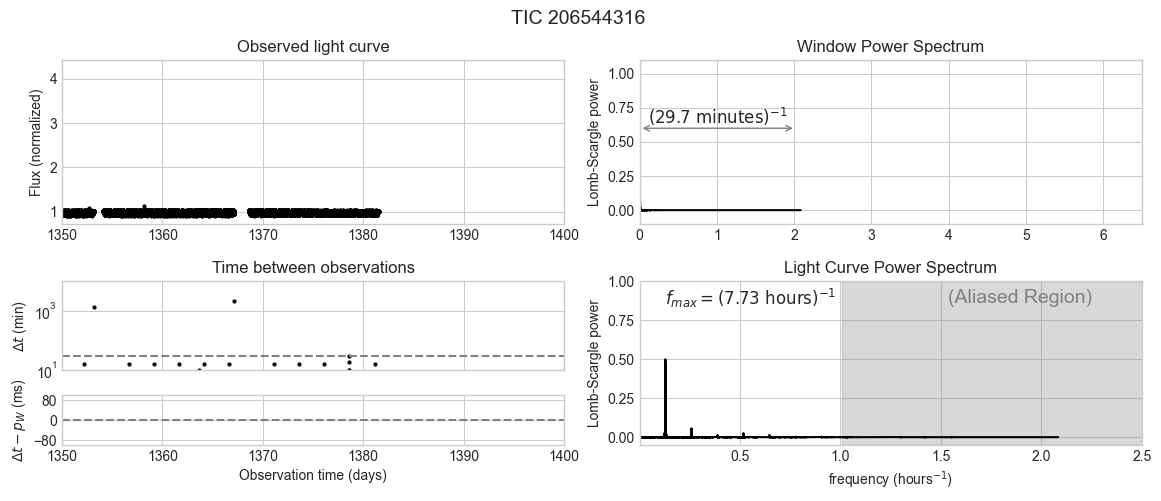

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from scipy.signal import savgol_filter


plt.style.use('seaborn-v0_8-whitegrid')

mask = np.isfinite(df["TIME"]) & np.isfinite(df["FLUX"])
time = df["TIME"][mask]
flux = df["FLUX"][mask]
flux_err = df["FLUX_ERR"][mask]

# --- 1. Detrend flux (Savitzky–Golay filter) ---
# window length ~101 points (~50 min for 30-min cadence), poly order=2
trend = savgol_filter(flux, 101, 2)
flux_detrended = flux / trend - 1.0   # normalize around 0

ls = LombScargle(time, flux, center_data=False, fit_mean=False)
freqW, powerW = ls.autopower(minimum_frequency=0,
                             maximum_frequency=50)

# Find the maximum near 2 hours
f, p = ls.autopower(minimum_frequency=1.95*24,
                    maximum_frequency=2.05*24,
                    samples_per_peak=100)
f_ny = f[np.argmax(p)]

t_sorted = np.sort(df['TIME'])
p_ny = 24 * 60 * 60 / f_ny
delta_t = (t_sorted[1:] - t_sorted[:-1]) * 24 * 60 * 60
ls = LombScargle(df['TIME'], df['FLUX'], df['FLUX_ERR'])
freq, power = ls.autopower(minimum_frequency=0,
                           maximum_frequency=50)

fmax = freq[np.argmax(power)] / 24

fig, ax = plt.subplots(2, 2, figsize=(12, 5))

fig.suptitle('TIC 206544316', size=14)
fig.subplots_adjust(hspace=0.35, wspace=0.15, left=0.07, right=0.97)

# upper left
ax[0, 0].plot(time, flux , 'ok', markersize=2, rasterized=True)
ax[0, 0].set(ylabel='Flux (normalized)',
             title='Observed light curve',
             xlim=(1350, 1400))

# bottom left
left, bottom, width, height = ax[1, 0].get_position().bounds
ax[1, 0].set_position([left, bottom + 0.15, width, height-0.15])
inset = fig.add_axes([left, bottom, width, 0.1])

ax[1, 0].plot(t_sorted[:-1], delta_t / 60, 'ok', markersize=2, rasterized=True)
ax[1, 0].axhline(p_ny / 60, color='gray', linestyle='--')
ax[1, 0].set(xlim=ax[0, 0].get_xlim(),
             ylim=(10, 10000),
             yscale='log',
             ylabel='$\Delta t$ (min)',
             title='Time between observations')
ax[1, 0].xaxis.set_major_formatter(plt.NullFormatter())

inset.plot(t_sorted[:-1], 1000 * (delta_t - p_ny), 'ok', markersize=2, rasterized=True)
inset.axhline(0, color='gray', linestyle='--')
inset.set(xlim=ax[0, 0].get_xlim(),
          ylim=(-100, 100),
          xlabel='Observation time (days)',
          ylabel='$\Delta t - p_{W}$ (ms)')
inset.yaxis.set_major_locator(plt.MaxNLocator(3));

# Upper right
ax[0, 1].plot(freqW / 24, powerW, '-k', rasterized=True);
ax[0, 1].set(xlim=(0, 6.5),
             ylim=(-0.1, 1.1),
             ylabel='Lomb-Scargle power',
             title='Window Power Spectrum');
ax[0, 1].annotate('', (0, 0.6), (f_ny / 24, 0.6),
                  arrowprops=dict(arrowstyle='<->', color='gray'));
ax[0, 1].text(f_ny / 48, 0.6, r'$({0:.1f}\ {{\rm minutes}})^{{-1}}$'.format(24 * 60 / f_ny),
              size=12, ha='center', va='bottom');

# Lower right
ax[1, 1].plot(freq / 24, power, '-k', rasterized=True)
ax[1, 1].fill_between([0.5 * f_ny / 24, 1.5 * f_ny / 24], -0.05, 1,
                      color='gray', alpha=0.3)
ax[1, 1].text(2.25, 0.95, r"(Aliased Region)", size=14, color='gray', ha='right', va='top')
ax[1, 1].text(fmax, 0.85, r"$f_{{max}}=({0:.2f}\ {{\rm hours}})^{{-1}}$".format(1 / fmax),
              size=12)
ax[1, 1].set(xlim=(0.001, 2.5),
             ylim=(-0.05, 1.0),
             xlabel='frequency (hours$^{-1}$)',
             ylabel='Lomb-Scargle power',
             title='Light Curve Power Spectrum');

Best frequency (safe region) = 0.1297 h^-1
Best period = 7.71 ± 0.001317 h (= 0.321324 ± 0.000055 d)


C:\Users\pavib\AppData\Local\Temp\ipykernel_22020\1576383749.py:55: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.savefig("Customized LS 206544316 periodogram", dpi=300)
C:\Users\pavib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


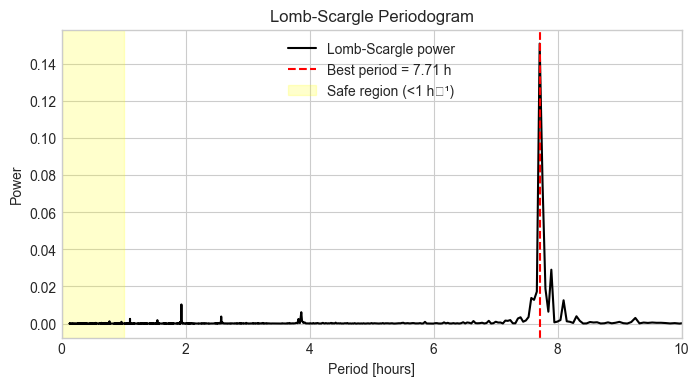

In [7]:
time = data['TIME']       # in days
flux = data['FLUX']

# --- Remove NaNs ---
mask = ~np.isnan(flux)
time = time[mask]
flux = flux[mask]

# --- Convert time to hours ---
time_hours = time * 24.0

# --- Define frequency grid ---
fmax = 7.73  # h^-1, maximum frequency to search
freq = np.linspace(0.01, fmax, 10000)  # in h^-1



# --- Compute Lomb-Scargle power ---
ls = LombScargle(time_hours, flux)
power = ls.power(freq)

# --- Safe (unshaded) region: frequencies below 1 h^-1 ---
safe_region = (freq < 1.0) & (~np.isnan(power))
if np.sum(safe_region) == 0:
    raise ValueError("No valid points in safe region (<1 h^-1)")

# --- Find the frequency of the maximum power in safe region ---
best_freq = freq[safe_region][np.argmax(power[safe_region])]

# --- Convert to period ---
best_period_hours = 1.0 / best_freq
best_period_days = best_period_hours / 24.0

# --- Conservative period uncertainty from time baseline ---
T = time_hours.max() - time_hours.min()  # total baseline in hours
delta_f = 1.0 / T
period_error = delta_f / (best_freq**2)

# --- Print results ---
print(f"Best frequency (safe region) = {best_freq:.4f} h^-1")
print(f"Best period = {best_period_hours:.2f} ± {period_error:.6f} h "
      f"(= {best_period_days:.6f} ± {period_error/24:.6f} d)")

# --- Plot periodogram ---
plt.figure(figsize=(8,4))
plt.plot(1/freq, power, 'k-', label='Lomb-Scargle power')
plt.axvline(best_period_hours, color='r', linestyle='--', label=f'Best period = {best_period_hours:.2f} h')
plt.axvspan(0, 1/1.0, color='yellow', alpha=0.2, label='Safe region (<1 h⁻¹)')  # highlight safe region
plt.xlabel('Period [hours]')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')

plt.legend()
plt.xlim(0, 10)  # adjust to typical period range
plt.savefig("Customized LS 206544316 periodogram", dpi=300)
plt.show()